In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


plt.style.use('default')
# This next line tells jupyter to render the images inline
%matplotlib inline
import matplotlib_inline
# This renders your figures as vector graphics AND gives you an option to download a PDF too
matplotlib_inline.backend_inline.set_matplotlib_formats('svg', 'pdf')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Matplotlib review

Today we will review some of the things we've learned so far about Matplotlib, and then take them a bit further to prepare you better for Homework 2.

### Part 1: Projections

Let's load a data set with transactions from a bakery.

In [2]:
bakery = pd.read_csv('./bakery.csv')
bakery

,TransactionNo,Items,DateTime,Daypart,DayType
0,1,Bread,2016-10-30 09:58:11,Morning,Weekend
1,2,Scandinavian,2016-10-30 10:05:34,Morning,Weekend
2,2,Scandinavian,2016-10-30 10:05:34,Morning,Weekend
3,3,Hot chocolate,2016-10-30 10:07:57,Morning,Weekend
4,3,Jam,2016-10-30 10:07:57,Morning,Weekend
...,...,...,...,...,...
20502,9682,Coffee,2017-09-04 14:32:58,Afternoon,Weekend
20503,9682,Tea,2017-09-04 14:32:58,Afternoon,Weekend
20504,9683,Coffee,2017-09-04 14:57:06,Afternoon,Weekend
20505,9683,Pastry,2017-09-04 14:57:06,Afternoon,Weekend


We see there's information about "part" and "type" of day in the data. We can quickly check what proportion of transactions happens in each:

In [3]:
bakery['Daypart'].value_counts(normalize=True)

Daypart
Afternoon    0.564149
Morning      0.409811
Evening      0.025357
Night        0.000683
Name: proportion, dtype: float64

In [4]:
bakery['DayType'].value_counts(normalize=True)

DayType
Weekday    0.624518
Weekend    0.375482
Name: proportion, dtype: float64

There seem to be very few transactions at night. For simplicity, let's drop them:

In [5]:
bakery = bakery[bakery['Daypart']!='Night']

Now let's visualize these proportions by creating a quick pie chart using Matplotlib's built-in ``.pie()`` method:

In [6]:
# Create a new dataframe with counts of items by daypart
bakery_by_daypart = (
    bakery.groupby('Daypart')
    .agg(
        num_items = ('Items', 'count'),
    ).reset_index()
)
bakery_by_daypart

,Daypart,num_items
0,Afternoon,11569
1,Evening,520
2,Morning,8404


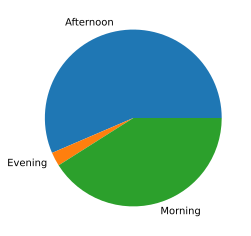

In [7]:
fig, subfig = plt.subplots(figsize = (4,4))

subfig.pie(
    x      = bakery_by_daypart['num_items'], 
    labels = bakery_by_daypart['Daypart']
)

plt.show()

We've learned before that it is much harder to accurately compare angles than other encodings (e.g., lengths, positions). So let's convert it to a donut chart:

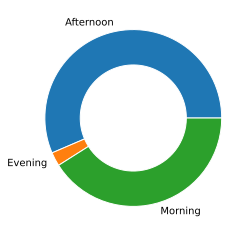

In [8]:
fig, subfig = plt.subplots(figsize = (4,4))

subfig.pie(
    x      = bakery_by_daypart['num_items'], 
    labels = bakery_by_daypart['Daypart'],
    wedgeprops = dict(width = 0.4, edgecolor = 'white') # set width of wedges to 40%
)

plt.show()

Now how can we also encode whether it's a weekend or a weekday?

In [9]:
# Let's put counts by daytype in the outer donut
outer_donut = bakery.groupby('DayType').count()['Items']
outer_donut

DayType
Weekday    12803
Weekend     7690
Name: Items, dtype: int64

In [10]:
# Let's put counts by daytype & daypart in the inner donut
inner_donut = bakery.groupby(['DayType', 'Daypart']).count()['Items']
inner_donut

DayType  Daypart  
Weekday  Afternoon    7273
         Evening       356
         Morning      5174
Weekend  Afternoon    4296
         Evening       164
         Morning      3230
Name: Items, dtype: int64

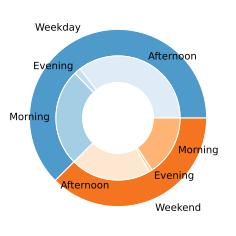

In [11]:
fig, subfig = plt.subplots(figsize = (4,4))

# Outer donut
subfig.pie(
    x      = outer_donut, 
    labels = outer_donut.index,
    radius = 1,
    wedgeprops = dict(width = 0.3, edgecolor = 'white'),
    colors = [plt.cm.Blues(150), plt.cm.Oranges(150)]
)

# Inner donut
subfig.pie(
    x      = inner_donut, 
    labels = inner_donut.index.get_level_values(1),
    radius = 0.7,
    wedgeprops = dict(width = 0.3, edgecolor = 'white'),
    colors = [plt.cm.Blues(30*x) for x in range(1,4)] + [plt.cm.Oranges(30*x) for x in range(1,4)],
    labeldistance = 1.1
)

plt.show()

So this is pie chart and donut chart created using Matplotlib's built-in `.pie()` method. Which you should probably use if you're going for an ordinary piechart.

But Matplotlib is much more flexible than we've seen so far. As an exercise, let's try to recreate this same chart without using `.pie()`!

How? Well, let's think of this donut chart as a "weird" bar chart. Look at this bar chart below. It has `x`, or the "position" along the x-axis---here, a categorical variable. It has a `height`, which is simply how tall each bar is, encoded by our sales count.

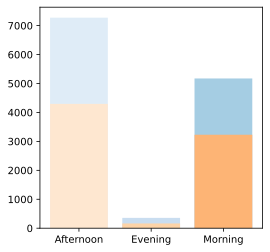

In [12]:
fig, subfig = plt.subplots(figsize = (4,4))

inner_donut = bakery.groupby(['DayType', 'Daypart']).count()['Items']

subfig.bar(
    height = inner_donut, 
    x = inner_donut.index.get_level_values(1),
    color = [plt.cm.Blues(30*x) for x in range(1,4)] + [plt.cm.Oranges(30*x) for x in range(1,4)]
)

plt.show()

But that's the conventional bar chart setup we're used to. If we wanted to, we can modulate other parameters of the bars, such as their widths, bottom starting positions, etc. We can set them to constant values, or tie them to our variables:

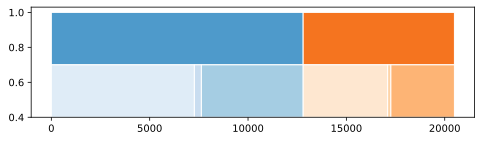

In [13]:
fig, subfig = plt.subplots(figsize = (8,2))

# Count by daytype
outer_donut = bakery.groupby('DayType').count()['Items']
# To arrange each daytype's bar we need to keep track of cumulative width of previous types:
outer_donut_edges = [0] + list(np.cumsum(outer_donut[:-1]))

# Top bar
subfig.bar(
    x = outer_donut_edges,
    width = outer_donut,
    bottom = 0.7,
    height = 0.3,
    edgecolor = 'white',
    linewidth = 1,
    align = 'edge',
    color = [plt.cm.Blues(150), plt.cm.Oranges(150)]
)

# Count by daytype and daypart
inner_donut = bakery.groupby(['DayType', 'Daypart']).count()['Items']
# To arrange each type's bar we need to keep track of cumulative width of previous types:
inner_donut_edges = [0] + list(np.cumsum(inner_donut[:-1]))

# Bottom bar
subfig.bar(
    x = inner_donut_edges,
    width = inner_donut,
    bottom = 0.4,
    height = 0.3,
    edgecolor = 'white',
    linewidth = 1,
    align = 'edge',
    color = [plt.cm.Blues(30*x) for x in range(1,4)] + [plt.cm.Oranges(30*x) for x in range(1,4)]
)

plt.show()

You may see where this is going now. Hint: imagine wrapping the above bar chart around a circle.

![Polar coordinates grid](./polar_grid.png)

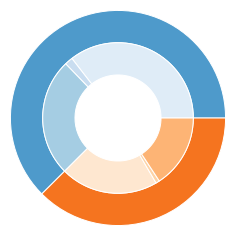

In [14]:
fig, subfig = plt.subplots(figsize = (4,4), subplot_kw = dict(projection = 'polar'))

# Count by daytype
outer_donut = bakery.groupby('DayType').count()['Items']
# Convert count to a normalized angle
outer_donut = [x*2*np.pi / sum(outer_donut) for x in outer_donut]
# To arrange each daytype's bar we need to keep track of cumulative angle of previous types:
outer_donut_edges = [0] + list(np.cumsum(outer_donut[:-1]))

# Outer donut
subfig.bar(
    x = outer_donut_edges,
    width = outer_donut,
    bottom = 0.7,
    height = 0.3,
    edgecolor = 'white',
    linewidth = 1,
    align = 'edge',
    color = [plt.cm.Blues(150), plt.cm.Oranges(150)]
)

# Count by daytype and daypart
inner_donut = bakery.groupby(['DayType', 'Daypart']).count()['Items']
# Convert count to a normalized angle
inner_donut = [x*2*np.pi / sum(inner_donut) for x in inner_donut]
# To arrange each ype's bar we need to keep track of cumulative angle of previous types:
inner_donut_edges = [0] + list(np.cumsum(inner_donut[:-1]))

# Inner donut
subfig.bar(
    x = inner_donut_edges,
    width = inner_donut,
    bottom = 0.4,
    height = 0.3,
    edgecolor = 'white',
    linewidth = 1,
    align = 'edge',
    color = [plt.cm.Blues(30*x) for x in range(1,4)] + [plt.cm.Oranges(30*x) for x in range(1,4)]
)

subfig.set_axis_off()
plt.show()

### Part 2: Categorical data

With Matplotlib's power and flexibility come some difficulties: there are many commonly-used types of charts that are not as straightforward to make using commonly-used data sets.

Let's make a boxplot in Matplotlib:
https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.boxplot.html#matplotlib.axes.Axes.boxplot

Here I'm generating some fake data: a bunch of bleths for each of foo, bar, and baz. This is probably the most common format you'll see data in. Besides being common, it's what is called "tidy" data: each row is an observation, each column is a variable. But that's not the format Matplotlib's `.boxplot()` wants the data in.

In [15]:
my_df = pd.DataFrame(
    {
        'name' : np.random.choice(['foo', 'bar', 'baz'], size = 500),
        'bleth' : np.random.randint(low = 0, high = 100, size = 500)
    }
)
my_df

,name,bleth
0,foo,92
1,bar,99
2,baz,59
3,bar,87
4,baz,95
...,...,...
495,foo,62
496,bar,51
497,baz,79
498,baz,18


Create a boxplot of bleths by name:

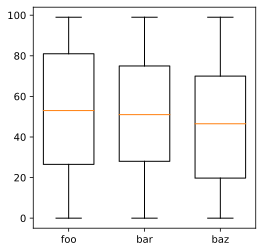

In [16]:
fig, subfig = plt.subplots(figsize = (4,4))

### CODE HERE ###

plt.show()

# Seaborn

We often have a chart in mind, and we don't have to be picky about how to achieve it in Python. Seaborn is a good library that has a lot of very useful advanced plots built in that are tricky to re-create with Matplotlib.

We won't cover all the plots here, just give you a flavor of what's possible.

In [17]:
import seaborn as sns

Now, let's recreate the exact same boxplot in Seaborn:

<Axes: xlabel='name', ylabel='bleth'>

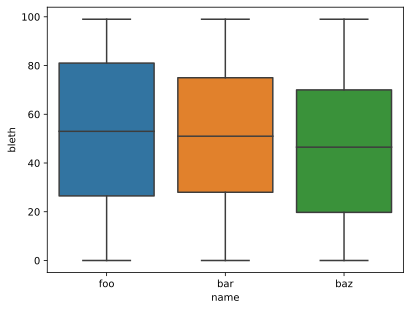

In [18]:
sns.boxplot(
    data = my_df,
    x = 'name',
    y = 'bleth'
)

You can see the slightly different syntax as well. Seaborn is very dataframe-centric, which has its pros and cons. Instead of passing separate lists or series, we specify a dataframe, and then map variables from the data frame to a chart's attributes.

To see this better, let's generate a couple more numeric variables and create a scatterplot (that Seaborn calls a relational plot for some reason?): 

In [19]:
my_df['wooth'] = np.random.randint(low = 30, high = 300, size = 500)
my_df['size'] = np.random.randint(low = 1, high = 5, size = 500)

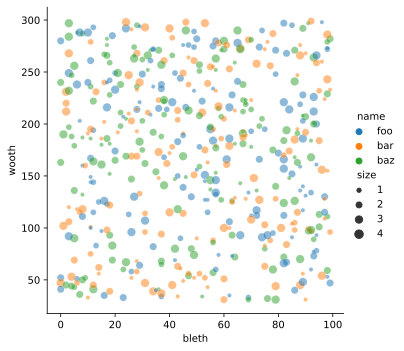

In [20]:
sns.relplot(
    data = my_df,
    x = 'bleth',
    y = 'wooth',
    hue = 'name',
    size = 'size',
    alpha = 0.5
)

We can even quickly create a faceted plot simply by tying `col = ` to a variable---no need to manually set up subfigures:

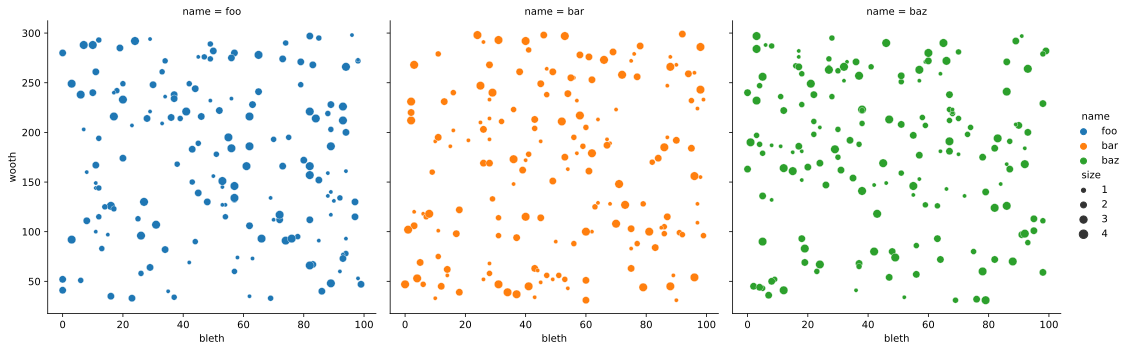

In [21]:
sns.relplot(
    data = my_df,
    x = 'bleth',
    y = 'wooth',
    hue = 'name',
    size = 'size',
    col = 'name'
)

Seaborn has very user-friendly and powerful categorical plots. We've seen the boxplot already, but there's also strip plots, beeswarm plots, violin plots---all of which you can easily split into subcategories:

In [22]:
my_df['is_musician'] = np.random.choice([True, False], size = 500)

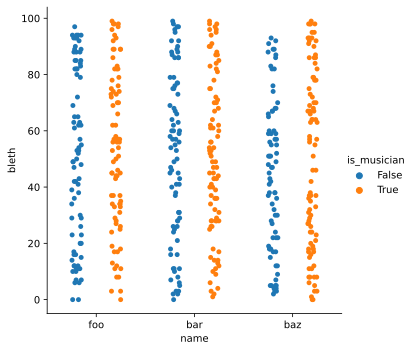

In [23]:
sns.catplot(
    data=my_df,
    kind = "strip", 
    x = "name", 
    y = "bleth", 
    hue = "is_musician",
    dodge = True)


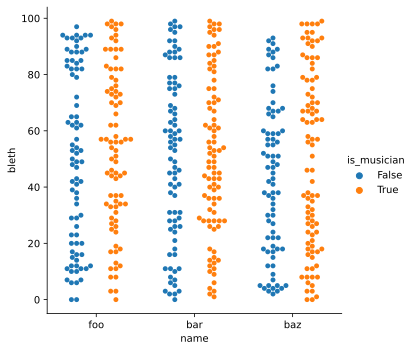

In [24]:
sns.catplot(
    data=my_df,
    kind = "swarm", 
    x = "name", 
    y = "bleth", 
    hue = "is_musician",
    dodge = True)


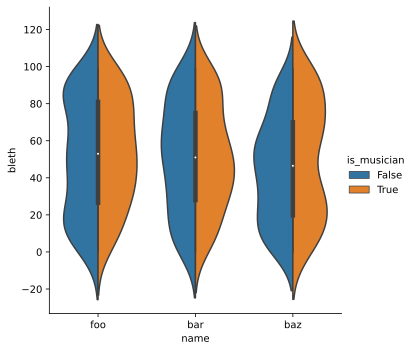

In [25]:
sns.catplot(
    data=my_df,
    kind = "violin", 
    x = "name", 
    y = "bleth", 
    hue = "is_musician",
    split = True)


For datasets with categories, we can use "joint plots" to get an overview of the distributions and their relationships:

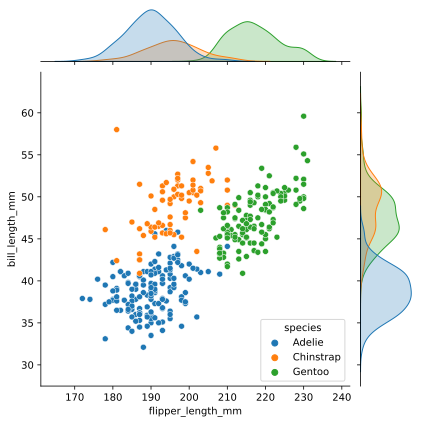

In [26]:
penguins = sns.load_dataset("penguins")
sns.jointplot(
    data=penguins, x="flipper_length_mm", y="bill_length_mm", hue="species")

And we can create scatterplot matrices (pairplots in Seaborn) to show relationships:

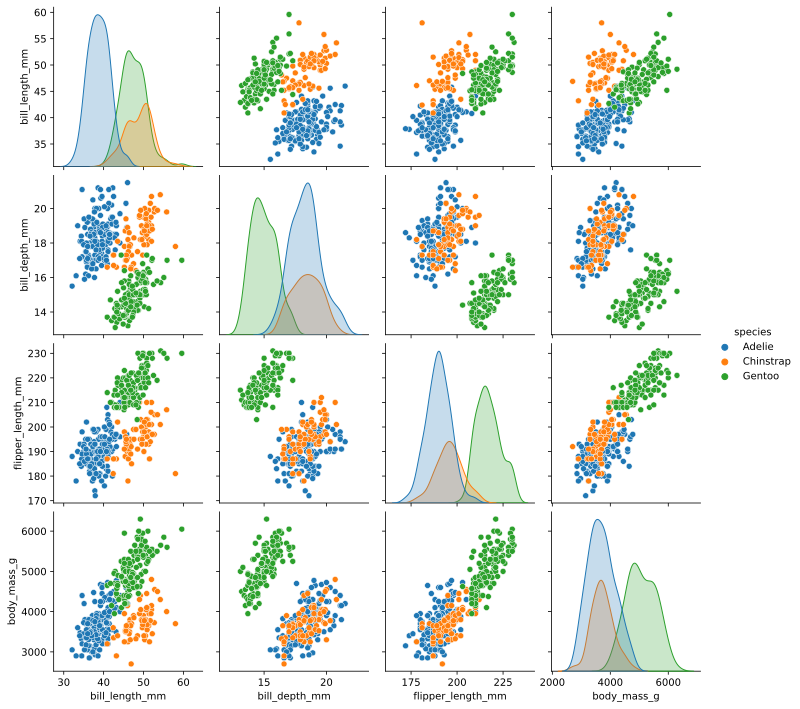

In [27]:
sns.pairplot(data=penguins, hue="species")